In [1]:
from utils.utils import *
from load_data import load_data
from trainer import trainer

import torch.optim as optim
import torch.nn as nn
import torch

from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
)



In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import ast
class IMDB(Dataset):
    def __init__(self, file) -> None:
        super().__init__()
        file = open(file, 'r', encoding='utf-8')
        data = pd.read_csv(file, sep='\t')
        columns = ['input_ids', 'input_mask', 'input_type_ids', 'label_ids']
        self.tensors = [torch.tensor(data[c].apply(lambda x: ast.literal_eval(x)), dtype=torch.long) \
                            for c in columns[:-1]]
        self.tensors.append(torch.tensor(data[columns[-1]]))
        file.close()
    
    def __len__(self):
        return self.tensors[0].size(0)
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)
    

In [62]:
file ='data/imdb_sup_test.txt'
dataset = IMDB(file)
dataiter = DataLoader(dataset, batch_size=32, shuffle=True)

valid_file ='data/sani.txt'
valid_dataset = IMDB(valid_file)
valid_dataiter = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [65]:
# load model
device = torch.device('cuda')
config = AutoConfig.from_pretrained("bert-base-uncased")
#print(config)
model = AutoModelForSequenceClassification.from_config(config=config).to(device)
#model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

In [66]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [67]:
print(len(valid_dataset))
print(len(valid_dataiter))

500
16


In [68]:
# test셋은 제대로 학습하는 지 체크...
import logging

model.train()
logging.basicConfig(level=logging.INFO)
acc = True
total_cor = 0
total_try = 0
epochs = 100
loss = {'sup': []}

for n in range(epochs):
    v_suc = 0
    for step, batch in enumerate(dataiter):
        model.train()
        optimizer.zero_grad()
        sup_input_ids, sup_input_mask, sup_input_type_ids, label_ids = (t.to(device) for t in batch)
        sup_outputs = model(sup_input_ids, sup_input_mask, sup_input_type_ids)
        sup_loss = criterion(sup_outputs.logits, label_ids)
        sup_loss.backward()
        optimizer.step()
        
        ## logging
        loss['sup'].append(sup_loss)
        pred = torch.argmax(sup_outputs.logits,dim=1)
        acc = torch.sum(pred==label_ids)/len(label_ids)
        total_cor += torch.sum(pred==label_ids)
        total_try += len(label_ids)
        if step % 4 == 3:
            logging.info(f'Currnent   Step: {step+1}/{len(dataiter)} of epoch {n+1}/{epochs}')
            logging.info(f'Currnent  Loss : {sup_loss}')
            logging.info(f'Currnent   Acc : {acc :.3f}')
            logging.info(f'Total      Acc : {total_cor/total_try :.3f}')
        pass
    logging.info(f'Valid     ON ')
    for v_step, v_batch in enumerate(valid_dataiter):
        model.eval()
        sup_input_ids, sup_input_mask, sup_input_type_ids, label_ids = (t.to(device) for t in v_batch)
        sup_outputs = model(sup_input_ids, sup_input_mask, sup_input_type_ids)
        v_pred = torch.argmax(sup_outputs.logits,dim=1)
        v_suc += torch.sum(v_pred==label_ids)
        if v_step % 4 == 3:
            logging.info(f'Currnent   Step: {v_step+1}/{len(valid_dataiter)} of epoch {n+1}/{epochs}')
            logging.info(f'Valid Current Acc : {torch.sum(v_pred==label_ids)/len(label_ids) :.3f}')
    logging.info(f'Valid   ToTal Acc : {v_suc/len(valid_dataset) :.3f}')


INFO:root:Currnent   Step: 4/782 of epoch 1/100
INFO:root:Currnent  Loss : 0.6697055697441101
INFO:root:Currnent   Acc : 0.562
INFO:root:Total      Acc : 0.523
INFO:root:Currnent   Step: 8/782 of epoch 1/100
INFO:root:Currnent  Loss : 0.7120981216430664
INFO:root:Currnent   Acc : 0.438
INFO:root:Total      Acc : 0.469
INFO:root:Currnent   Step: 12/782 of epoch 1/100
INFO:root:Currnent  Loss : 0.6941494941711426
INFO:root:Currnent   Acc : 0.594
INFO:root:Total      Acc : 0.477
INFO:root:Currnent   Step: 16/782 of epoch 1/100
INFO:root:Currnent  Loss : 0.6712296009063721
INFO:root:Currnent   Acc : 0.594
INFO:root:Total      Acc : 0.492
INFO:root:Currnent   Step: 20/782 of epoch 1/100
INFO:root:Currnent  Loss : 0.672853410243988
INFO:root:Currnent   Acc : 0.625
INFO:root:Total      Acc : 0.508
INFO:root:Currnent   Step: 24/782 of epoch 1/100
INFO:root:Currnent  Loss : 0.685321569442749
INFO:root:Currnent   Acc : 0.562
INFO:root:Total      Acc : 0.503
INFO:root:Currnent   Step: 28/782 of e

KeyboardInterrupt: 

INFO:root:Save figures at sani/results/


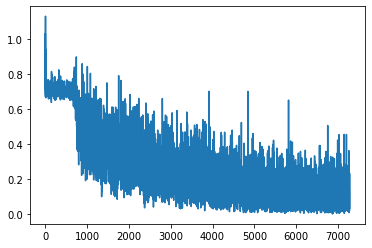

In [69]:
from utils.utils import save_fig
fig_PATH = "sani/results/"
save_fig(loss, fig_PATH, True)

In [86]:
import torch

a = torch.rand((3,5))
a
id = a < 0.6
b = a[id]
b.shape


torch.Size([10])

In [4]:
import torch

a = torch.zeros(0)
if a.size():
    print(1)
    print(a.)

1
torch.Size([0])
